# Agent-Based Simulation 

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import random 
import pandas as pd
from matplotlib.collections import LineCollection
import matplotlib as mpl
import numpy as np
from scipy import optimize as opt
from scipy import integrate as intg
from scipy.optimize import least_squares
from scipy.stats import beta
from scipy.stats import bernoulli
from scipy.stats import cumfreq, beta
from utils import Agent, kill
%matplotlib inline
plt.style.use('../notebook.mplstyle')

SEED = 1


## Exogenous Parameters


In [2]:
# Setting exogenous parameters
def reset_exog_params():
    global Bm, Bw, bm_vals, bw_vals, δ, um, uw, Fm, Fw, λm, λw, T  
    Bm = 10
    Bw = 10
    bm_vals = range(1,Bm+1) 
    bw_vals = range(1,Bw+1)
    
    δ = 0.97
    um = lambda θ : θ 
    uw = lambda θ : θ
    Fm = beta(2,4)
    Fw = beta(2,4)
    λm = 30
    λw = 30

    T = 32

## Steady State with Cutoff Strategies

In [3]:
def steady_state(μ, ω, verbose=False): 
    # Computing z's
    zm = []
    for b in bm_vals:
        if b==Bm:
            zm.append(1-δ*Fw.cdf(μ[Bm-1]))
        else:    
            z=1
            for i in range(1, Bm-b+1): 
                z *= ((δ*(1-Fw.cdf(μ[Bm-i])))/(1-δ*Fw.cdf(μ[Bm-i-1])))   
            zm.append(z)  
        
    zw = []
    for b in bw_vals:
        if b==Bw:
            zw.append(1-δ*Fw.cdf(ω[Bw-1]))
        else:    
            z=1
            for i in range(1, Bw-b+1): 
                z *= ((δ * (1-Fm.cdf(ω[Bw-i])))/(1-δ*Fm.cdf(ω[Bw-i-1])))
            zw.append(z)    
    
    # Computing steady-state masses
    Nm = λm * ((zm[Bm-1] - δ * zm[0] * (1 - Fw.cdf(μ[0]))) / ((1-δ) * zm[Bm-1]))
    Nw = λw * ((zw[Bw-1] - δ * zw[0] * (1 - Fm.cdf(ω[0]))) / ((1-δ) * zw[Bw-1]))   
    
    # Computing steady state distribution over budgets 
    Pbm = [(λm / (Nm * zm[Bm-1])) * zm[b] for b in range(Bm-1)]
    Pbw = [(λw / (Nw * zw[Bw-1])) * zw[b] for b in range(Bw-1)]
    Pbm.append((λm / (Nm * zm[Bm-1])))
    Pbw.append((λw / (Nw * zw[Bw-1]))) 
    
    # Computing tightness and alpha
    if Nw>Nm:
        τm = 1
    else:
        τm = Nw/Nm 
        
    τw = τm *(Nm/Nw) 
    αm = (τm*δ)/(1-δ*(1-τm))
    αw = (τw*δ)/(1-δ*(1-τw))
    return Nm, Nw, Pbm, Pbw, τm, τw, αm, αw

## Two-Sided Search Equilibrium Conditions 


In [4]:
# Optimality conditions
def SME(x): 
    # Compute steady state 
    Nm, Nw, Pbm, Pbw, τm, τw, αm, αw = steady_state(x[:Bm], x[Bm:])
    
    Um = um
    Uw = uw
    # Computing ex-ante expected utilities 
    
    # Initialysing system of equilibrium equations
    E = np.empty(2*Bm + 2*Bw + 2)
    
    # Initial conditions 
    E[0] = (Um(x[0]) 
            - αm * Um(x[0]) * Fw.cdf(x[0]) 
            - αm * intg.quad(lambda t: Um(t) * Fw.pdf(t), x[0], 1)[0]) 
    
    E[Bm] = (Uw(x[Bm]) 
            - αw * Uw(x[Bm]) * Fm.cdf(x[Bm]) 
            - αw * intg.quad(lambda t: Uw(t) * Fm.pdf(t), x[Bm], 1)[0]) 
    
    # Intertemporal optimality conditions for men
    for b in range(1,Bm):
        E[b] = (Um(x[b]) 
                - αm * Um(x[b]) * Fw.cdf(x[b]) 
                - αm * Um(x[b-1])*(1-Fw.cdf(x[b-1])) 
                - αm * intg.quad(lambda t : Um(t) * Fw.pdf(t), x[b], x[b-1])[0])
    
    # Intertemporal optimality conditions for women
    for b in range(1,Bw):
        E[Bm+b] = (Uw(x[Bm+b]) 
                - αw * Uw(x[Bm+b]) * Fm.cdf(x[Bm+b]) 
                - αw * Uw(x[Bm+b-1])*(1-Fm.cdf(x[Bm+b-1])) 
                - αw * intg.quad(lambda t : Uw(t) * Fm.pdf(t), x[Bm+b], x[Bm+b-1])[0])
        
    # PMF unity sum conditions
    E[Bm+Bw] = sum(Pbm)-1
    E[Bm+Bw+1] = sum(Pbw)-1
    
    # PMF non-negativity conditions
    for b in range(Bm):
        E[Bm+Bw+2+b] = Pbm[b]-abs(Pbm[b])
        
    for b in range(Bw): 
        E[Bm+Bw+2+Bm+b] = Pbw[b]-abs(Pbw[b])    
        
    return E 

## Numerical Approximation of Steady State Equilibria 

In [5]:
reset_exog_params()
m_test = np.random.rand(Bm)#*0.5
w_test = np.random.rand(Bw)#*0.5  

print('μ0: ', m_test)
print('ω0: ', w_test)
print('')

x_start = np.concatenate((m_test, w_test), axis=None)
solution = least_squares(SME, x_start, bounds = (0,1), verbose=1) 

μ_star = solution.x[:Bm]
ω_star = solution.x[Bm:]
print('')
print('μ*', μ_star) 
print('ω*', ω_star) 
print('Loss:', round(solution.cost,6))

μ0:  [0.4921947  0.47040664 0.67257522 0.30691268 0.0037164  0.21170054
 0.21701583 0.96774572 0.54919018 0.29118501]
ω0:  [8.55366114e-04 7.79562933e-02 9.94181631e-01 4.86383882e-01
 3.13106123e-01 5.55225572e-01 8.01526355e-01 2.94568276e-01
 9.73665567e-03 2.95565561e-01]

`gtol` termination condition is satisfied.
Function evaluations 7, initial cost 2.1975e-01, final cost 8.7651e-17, first-order optimality 1.21e-09.

μ* [0.52652401 0.45591669 0.41087664 0.3772929  0.35035713 0.3278103
 0.30839845 0.29134883 0.27614946 0.26244259]
ω* [0.52652396 0.45591669 0.41087665 0.37729291 0.35035715 0.32781031
 0.30839847 0.29134885 0.27614948 0.26244261]
Loss: 0.0


In [6]:
# Computing steady state
Nm, Nw, Pbm, Pbw, τm, τw, αm, αw = steady_state(μ_star, ω_star, True)
print('Masses: ', round(Nm), round(Nw))
print('PMF check:', round(sum(Pbm),3), round(sum(Pbw),3))
print('Tightness: ', round(τm,2), round(τw,2))
print('Alphas: ', round(αm,2), round(αw,2)) 

ρm = sum([(1 - Fm.cdf(ω_star[b]))*Pbw[b] for b in range(Bw)])
ρw = sum([(1 - Fw.cdf(μ_star[b]))*Pbm[b] for b in range(Bm)])
print('Average Pr(right-swipe): ', round(ρm, 2), round(ρw, 2))

Masses:  559 559
PMF check: 1.0 1.0
Tightness:  1.0 1.0
Alphas:  0.97 0.97
Average Pr(right-swipe):  0.4 0.4


## Agent-Based Simulation

In [7]:
men = []
women = [] 
simulation = [] 
for t in range(0,T):
    print('t=',t)
    # Add new agents 
    for i, θ in enumerate(Fm.rvs(size=λm, random_state=SEED)):
        id = t*λm+i
        men.append(Agent(id, t, 'Male', θ, Bm, μ_star))

    for i, θ in enumerate(Fw.rvs(size=λw, random_state=SEED)):
        id = t*λw+i
        women.append(Agent(id, t, 'Female', θ, Bm, ω_star)) 
    print('arrivals done ')

    # Gameplay 
    random.shuffle(men)
    random.shuffle(women) 
    for m, w in zip(men, women): 
        am = m.swipe(w)
        aw = w.swipe(m)
        m.update(am, aw, w, t)
        w.update(aw, am, m, t)  

    print('gameplay done ')

    # Departures 
    men_deaths = bernoulli.rvs((1-δ), size=len(men)) 
    women_deaths = bernoulli.rvs((1-δ), size=len(women)) 
    for m, d in zip(men, men_deaths): 
        simulation.append(m.info(t))
        if (m.b == 0) or (d==1): 
            kill(m, men, t) 
    
    for w, d in zip(women, women_deaths): 
        simulation.append(w.info(t))
        if (w.b == 0) or (d==1): 
            kill(w, women, t) 

    print('departures done ')        

t= 0
arrivals done 
gameplay done 
departures done 
t= 1
arrivals done 
gameplay done 
departures done 
t= 2
arrivals done 
gameplay done 
departures done 
t= 3
arrivals done 
gameplay done 
departures done 
t= 4
arrivals done 
gameplay done 
departures done 
t= 5
arrivals done 
gameplay done 
departures done 
t= 6
arrivals done 
gameplay done 
departures done 
t= 7
arrivals done 
gameplay done 
departures done 
t= 8
arrivals done 
gameplay done 
departures done 
t= 9
arrivals done 
gameplay done 
departures done 
t= 10
arrivals done 
gameplay done 
departures done 
t= 11
arrivals done 
gameplay done 
departures done 
t= 12
arrivals done 
gameplay done 
departures done 
t= 13
arrivals done 
gameplay done 
departures done 
t= 14
arrivals done 
gameplay done 
departures done 
t= 15
arrivals done 
gameplay done 
departures done 
t= 16
arrivals done 
gameplay done 
departures done 
t= 17
arrivals done 
gameplay done 
departures done 
t= 18
arrivals done 
gameplay done 
departures done 
t= 

In [12]:
data = pd.DataFrame(simulation)
data.tail(40)

,id,time,birth,sex,attractiveness,budget,observed_rate,true_rate,matches,rs_given,rs_received
21942,865,31,28,Female,0.225474,7,1.000000,1.000000,[],"[801, 852, 467]",[]
21943,209,31,6,Female,0.133260,1,1.000000,1.000000,[],"[9, 213, 183, 164, 247, 392, 215, 681, 559]",[]
21944,498,31,16,Female,0.326592,1,0.333333,0.333333,"[504, 619]","[291, 69, 213, 504, 619, 372, 559, 214, 457]","[504, 619, 553, 826]"
21945,537,31,17,Female,0.251607,3,1.000000,1.000000,[],"[409, 558, 589, 347, 695, 662, 767]",[]
21946,396,31,13,Female,0.088139,2,1.000000,1.000000,[],"[222, 459, 527, 116, 633, 394, 494, 557]",[]
21947,815,31,27,Female,0.394706,8,0.666667,1.000000,"[559, 492]","[559, 492]","[470, 559, 492, 406]"
21948,607,31,20,Female,0.554554,2,0.800000,1.000000,"[566, 270, 236, 240, 261, 545, 284, 737]","[566, 270, 236, 240, 261, 545, 284, 737]","[566, 460, 270, 236, 240, 261, 545, 781, 284, ..."
21949,651,31,21,Female,0.678801,4,0.666667,1.000000,"[312, 421, 633, 180, 241, 694]","[312, 421, 633, 180, 241, 694]","[207, 312, 421, 633, 180, 241, 145, 610, 694, ..."
21950,835,31,27,Female,0.225474,7,1.000000,1.000000,[],"[504, 351, 847]",[]
21951,703,31,23,Female,0.268361,6,1.000000,0.250000,[],"[457, 694, 462, 633]",[802]


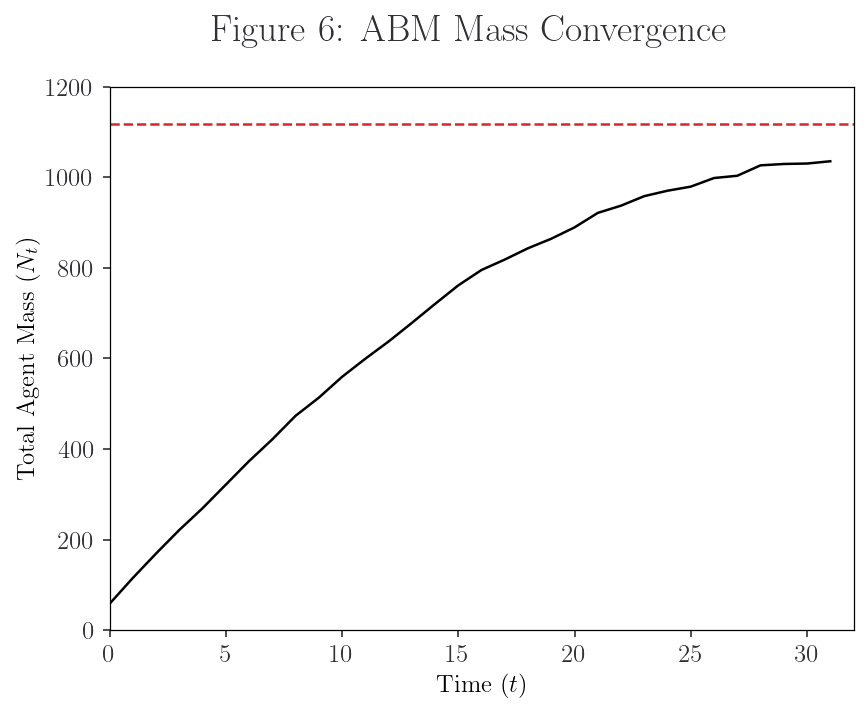

In [9]:
total_mass = data.groupby(['time']).size()
fig, ax = plt.subplots()
ax.set_xlim(0,T)
ax.axhline(y = Nm+Nw, color = 'tab:red', linestyle = '--')
ax.plot(range(0,T), total_mass, color='k')  
ax.set(xlabel=r'Time ($t$)', ylabel=r'Total Agent Mass ($N_t$)')
fig.suptitle('Figure 6: ABM Mass Convergence')
plt.savefig('../../figures/abm-total-conv.png')
plt.show()

In [10]:
mass_by_sex = data.groupby(['time', 'sex'], as_index=False).size() 
Nm_series = mass_by_sex[mass_by_sex.sex=='Male']['size']
Nw_series = mass_by_sex[mass_by_sex.sex=='Female']['size'] 

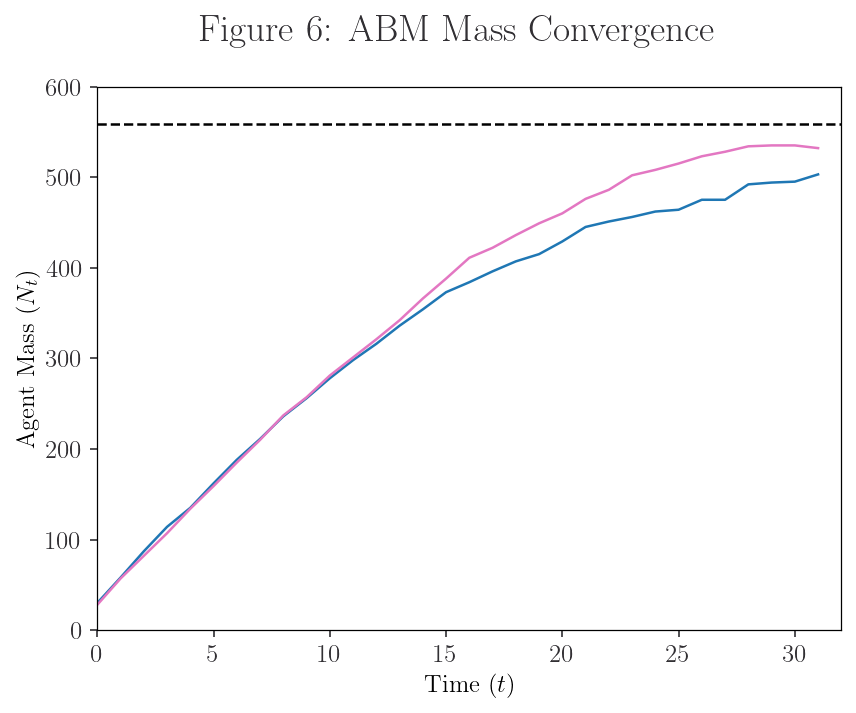

In [11]:
mass_by_sex = data.groupby(['time', 'sex'], as_index=False).size() 
Nm_series = mass_by_sex[mass_by_sex.sex=='Male']['size']
Nw_series = mass_by_sex[mass_by_sex.sex=='Female']['size']

fig, ax = plt.subplots()
ax.set_xlim(0,T)
if round(Nm)==round(Nw):
    ax.axhline(y = Nm, color = 'k', linestyle = '--') 
else:    
    ax.axhline(y = Nm, color = 'tab:blue', linestyle = '--')
    ax.axhline(y = Nw, color = 'tab:pink', linestyle = '--')
ax.plot(range(0,T), Nm_series, color='tab:blue') 
ax.plot(range(0,T), Nw_series, color='tab:pink') 
ax.set(xlabel=r'Time ($t$)', ylabel=r'Agent Mass ($N_t$)')
fig.suptitle('Figure 6: ABM Mass Convergence')
plt.savefig('../../figures/abm-conv.png')
plt.show()
